In [1]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

In [2]:
import os
import numpy as np
import imageio
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from tensorflow.keras.layers import Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from skimage.transform import resize

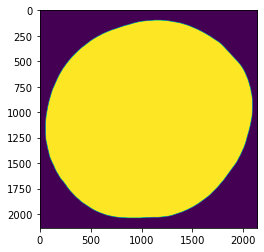

In [3]:
apple = imageio.imread('.\\datasets\\fruits\\apple\\apple_1.png')
banana = imageio.imread('.\\datasets\\fruits\\banana\\33867-8-banana.png')
plt.imshow(apple[:,:, 3])
plt.show()

In [4]:
OBJ_DIM = 224
apple = resize(np.array(apple),
                          (40, 40),
                          preserve_range=True).astype(np.uint8)
banana = resize(np.array(banana),
                          (40, 40),
                          preserve_range=True).astype(np.uint8)
a_H, a_W, a_C = apple.shape
b_H, b_W, b_C = banana.shape

# useful store these in an array
obj_data = [
  [apple, a_H, a_W, a_C],
  [banana, b_H, b_W, b_C],
]
class_names = ['Apple', 'Banana']

In [5]:
def custom_loss(y_true, y_pred):
    # target is a 8-tuple
    # (row, col, depth, width, class1, class2, object_appeared)

    bce = binary_crossentropy(y_true[:, :4], y_pred[:, :4]) # location
    cce = categorical_crossentropy(y_true[:, 4:6], y_pred[:, 4:6]) # object class
    bce2 = binary_crossentropy(y_true[:, -1], y_pred[:, -1]) # object appeared

    return bce * y_true[:, -1] + cce * y_true[:, -1] + 1 * bce2

In [6]:
def make_model():
    vgg = tf.keras.applications.VGG16(
        input_shape=[OBJ_DIM, OBJ_DIM, 3],
        include_top=False,
        weights='imagenet')
    x = Flatten()(vgg.output)
    x1 = Dense(4, activation='sigmoid')(x) # location
    x2 = Dense(2, activation='softmax')(x) # object class
    x3 = Dense(1, activation='sigmoid')(x) # object appeared
    x = Concatenate()([x1, x2])
    model = Model(vgg.input, x)
    #   model.compile(loss=custom_loss, optimizer=SGD(learning_rate=0.01, momentum=0.9))
    model.compile(loss=custom_loss, optimizer=Adam(lr=0.0001))
    return model

In [7]:
from glob import glob
backgrounds = []
background_files = glob('.\\datasets\\fruits\\background\\*.JPG')
for f in background_files:
    # Note: they may not all be the same size
    bg = np.array(image.load_img(f))
    backgrounds.append(bg)

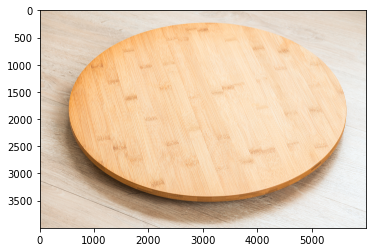

In [8]:
plt.imshow(backgrounds[1])

In [9]:
def scene_generator(batch_size=8):
    # generate image and targets
    while True:
        # Each epoch will have 50 batches. Why? No reason
        for _ in range(50):
            X = np.zeros((batch_size, OBJ_DIM, OBJ_DIM, 3))
            Y = np.zeros((batch_size, 7))

            for i in range(batch_size):
                # select a random background
                bg_idx = np.random.choice(len(backgrounds))
                bg = backgrounds[bg_idx]
                bg_h, bg_w, _ = bg.shape
                rnd_h = np.random.randint(bg_h - OBJ_DIM)
                rnd_w = np.random.randint(bg_w - OBJ_DIM)
                X[i] = bg[rnd_h:rnd_h+OBJ_DIM,rnd_w:rnd_w+OBJ_DIM].copy()

                # 33% no object, 33% + 33% for the 2 classes
                appear = (np.random.random() < 0.667)
                if appear:

                    # choose the fruit
                    fruit_idx = np.random.randint(2)
                    fruit, h, w, _ = obj_data[fruit_idx]

                    # resize object - make it bigger or smaller
                    scale = 0.5 + np.random.random()
                    new_height = int(h * scale)
                    new_width = int(w * scale)
                    obj = resize(
                          fruit,
                          (new_height, new_width),
                          preserve_range=True).astype(np.uint8) # keep it from 0..255

                    # maybe flip
                    if np.random.random() < 0.5:
                        obj = np.fliplr(obj)

                    # choose a random location to store the object
                    row0 = np.random.randint(OBJ_DIM - new_height)
                    col0 = np.random.randint(OBJ_DIM - new_width)
                    row1 = row0 + new_height
                    col1 = col0 + new_width

                    # can't 'just' assign obj to a slice of X
                    # since the transparent parts will be black (0)
                    mask = (obj[:,:,3] == 0) # find where the pokemon is 0
                    bg_slice = X[i,row0:row1,col0:col1,:] # where we want to place `obj`
                    bg_slice = np.expand_dims(mask, -1) * bg_slice # (h,w,1) x (h,w,3)
                    bg_slice += obj[:,:,:3] # "add" the pokemon to the slice
                    X[i,row0:row1,col0:col1,:] = bg_slice # put the slice back

                    # make targets

                    # location
                    Y[i,0] = row0/OBJ_DIM
                    Y[i,1] = col0/OBJ_DIM
                    Y[i,2] = (row1 - row0)/OBJ_DIM
                    Y[i,3] = (col1 - col0)/OBJ_DIM

                    # class
                    Y[i,4 + fruit_idx] = 1

                # did the pokemon appear?
                Y[i,6] = appear

            yield X / 255., Y

In [10]:
xx = None
yy = None
for x, y in scene_generator():
    xx, yy = x, y
    break

In [11]:
model = make_model()
model.fit(
    scene_generator(),
    steps_per_epoch=50,
    epochs=50,
)

Epoch 1/50
50/50 [==============================] - 14s 147ms/step - loss: 1.4611
Epoch 2/50
50/50 [==============================] - 7s 148ms/step - loss: 0.8408
Epoch 3/50
50/50 [==============================] - 7s 150ms/step - loss: 0.8086
Epoch 4/50
50/50 [==============================] - 7s 150ms/step - loss: 0.9053
Epoch 5/50
50/50 [==============================] - 8s 150ms/step - loss: 0.8043
Epoch 6/50
50/50 [==============================] - 8s 150ms/step - loss: 0.7950
Epoch 7/50
50/50 [==============================] - 8s 150ms/step - loss: 0.8921
Epoch 8/50
50/50 [==============================] - 8s 150ms/step - loss: 0.7506
Epoch 9/50
50/50 [==============================] - 8s 150ms/step - loss: 0.7380
Epoch 10/50
50/50 [==============================] - 8s 150ms/step - loss: 0.8400
Epoch 11/50
50/50 [==============================] - 8s 150ms/step - loss: 0.8944
Epoch 12/50
50/50 [==============================] - 8s 150ms/step - loss: 0.8291
Epoch 13/50
50/50 [=====

In [33]:
# Make predictions
def prediction_multiclass():
    # select a random background
    bg_idx = np.random.choice(len(backgrounds))
    bg = backgrounds[bg_idx]
    bg_h, bg_w, _ = bg.shape
    rnd_h = np.random.randint(bg_h - OBJ_DIM)
    rnd_w = np.random.randint(bg_w - OBJ_DIM)
    x = bg[rnd_h:rnd_h+OBJ_DIM,rnd_w:rnd_w+OBJ_DIM].copy()

    appear = (np.random.random() < 0.66)
    if appear:

        # choose a pokemon
        fruit_idx = np.random.randint(2)
        fruit, h, w, _ = obj_data[fruit_idx]

        # resize charmander - make it bigger or smaller
        scale = 0.5 + np.random.random()
        new_height = int(h * scale)
        new_width = int(w * scale)
        obj = resize(
            fruit,
            (new_height, new_width),
            preserve_range=True).astype(np.uint8) # keep it from 0..255

        # maybe flip
        if np.random.random() < 0.5:
            obj = np.fliplr(obj)

        # choose a random location to store the object
        row0 = np.random.randint(OBJ_DIM - new_height)
        col0 = np.random.randint(OBJ_DIM - new_width)
        row1 = row0 + new_height
        col1 = col0 + new_width

        # can't 'just' assign obj to a slice of X
        # since the transparent parts will be black (0)
        mask = (obj[:,:,3] == 0) # find where the pokemon is 0
        bg_slice = x[row0:row1,col0:col1,:] # where we want to place `obj`
        bg_slice = np.expand_dims(mask, -1) * bg_slice # (h,w,1) x (h,w,3)
        bg_slice += obj[:,:,:3] # "add" the pokemon to the slice
        x[row0:row1,col0:col1,:] = bg_slice # put the slice back
        actual_class = class_names[fruit_idx]
        print("true:", row0, col0, row1, col1, actual_class)
  
    # Predict
    X = np.expand_dims(x, 0) / 255.
    p = model.predict(X)[0]

    # Plot
    fig, ax = plt.subplots(1)
    ax.imshow(x.astype(np.uint8))
  
    # Draw the box
    if p[-1] > 0.5:
        row0 = int(p[0]*OBJ_DIM)
        col0 = int(p[1]*OBJ_DIM)
        row1 = int(row0 + p[2]*OBJ_DIM)
        col1 = int(col0 + p[3]*OBJ_DIM)
        class_pred_idx = np.argmax(p[4:6])
        class_pred = class_names[class_pred_idx]
        print("pred:", row0, col0, row1, col1, class_pred)
        rect = Rectangle(
            (p[1]*OBJ_DIM, p[0]*OBJ_DIM),
            p[3]*OBJ_DIM, p[2]*OBJ_DIM,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    else:
        print("pred: no object")
    plt.show()

true: 53 83 84 114 Banana
pred: 67 75 104 110 Banana


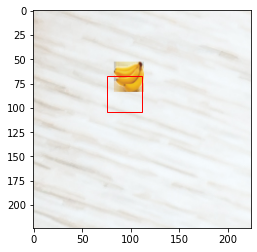

In [49]:
prediction_multiclass()